#  MODIS Water Clustering Analysis

Version: 0.1.0

Date modified: 05.01.2023

Modified by: Amanda Burke

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
##############################
#VERSION 4.2.0
# TILE_IN = 'Golden'#v4.2.0
# DATA_VERSION='v4.2.0'
# offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
##############################

##############################
#VERSION 2.0.0
TILE_IN = 'GLOBAL'#v4.2.0
DATA_VERSION='v2.0.0'
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
##############################

training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

GPU = True

MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
FRAC_LAND=0.5

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)


num_datapoints = 10000000

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip', '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip


## Functions

In [67]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

In [68]:

def plotting_clusters(X_w,X_l,kme_w,kme_l,kmeans_output_w,kmeans_output_l,n_cluster):
    fig = plt.figure(figsize = (25, 10))

    plt.suptitle(f'Kmeans Clustering {DATA_VERSION} Data, {n_cluster} Clusters')

    ax1 = plt.subplot(131)
    ax1.set_title(f'Land and Water Datapoints')
    ax1.scatter(X_w.values[:,0], X_w.values[:,1],label='Water')
    ax1.scatter(X_l.values[:,0], X_l.values[:,1],label='Land')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)
    ax1.set_xlabel(X_w.columns[0])
    ax1.set_ylabel(X_w.columns[1])
    ax1.legend(loc='lower right',fontsize="20")

    ax2 = plt.subplot(132)
    ax2.set_title(f'Water Datapoints Clustered: {len(X_water)} Examples')
    ax2.scatter(X_w.values[:,0], X_w.values[:,1],c=kmeans_output_w,cmap='tab10')
    ax2.scatter(kme_w.cluster_centers_[:,0],kme_w.cluster_centers_[:,1],
            label='Center Point',c='k',s=150)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='both', which='minor', labelsize=10)
    ax2.set_xlabel(X_w.columns[0])
    ax2.set_ylabel(X_w.columns[1])
    ax2.legend(loc='lower right',fontsize="20")

    ax3 = plt.subplot(133)
 
    ax3.set_title(f'Land Datapoints Clustered: {len(X_land)} Examples')
    ax3.scatter(X_l.values[:,0], X_l.values[:,1],c=kmeans_output_l,cmap='tab10')
    ax3.scatter(kme_l.cluster_centers_[:,0],kme_l.cluster_centers_[:,1],label='Center Point',c='k',s=150)
    ax3.tick_params(axis='both', which='major', labelsize=10)
    ax3.tick_params(axis='both', which='minor', labelsize=10)
    ax3.set_xlabel(X_l.columns[0])
    ax3.set_ylabel(X_l.columns[1])
    ax3.legend(loc='lower right',fontsize="20")

    plt.show()

## Start off with just surface reflectance bands 1,2

### Input data

In [39]:
colsToDrop = ['sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [40]:
colsToDrop

['sur_refl_b03_1',
 'sur_refl_b04_1',
 'sur_refl_b05_1',
 'sur_refl_b06_1',
 'sur_refl_b07_1',
 'ndvi',
 'ndwi1',
 'ndwi2']

In [69]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                # imbalance=True,
                                # frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

subset data shape: (4375821, 2), (4375821,)


#### separate the land and water points

In [70]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind = np.where(y>0.5)[0]
y_land_ind = np.where(y<0.5)[0]

#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water = X.iloc[y_water_ind,:]
y_water = y.iloc[y_water_ind]

X_land = X.iloc[y_land_ind,:]
y_land = y.iloc[y_land_ind]

In [71]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1


### kmeans land and water together

Text(0, 0.5, 'sur_refl_b02_1')

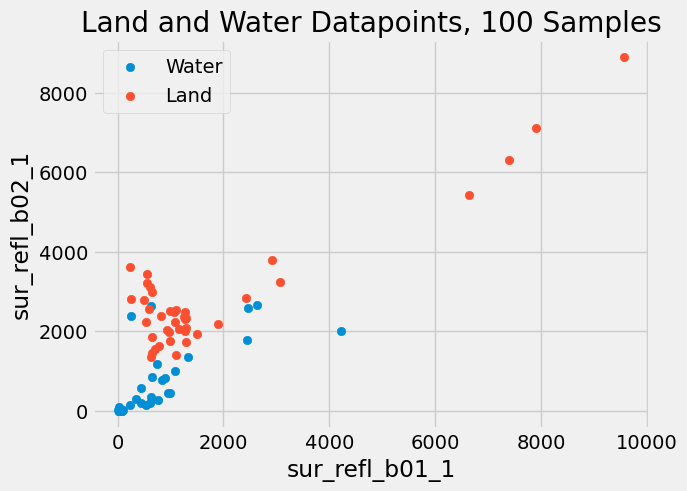

In [67]:
# plt.scatter(X_water.values[:,0], X_water.values[:,1],label='Water')
# plt.scatter(X_land.values[:,0], X_land.values[:,1],label='Land')
# plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_water.columns[0])
# plt.ylabel(X_water.columns[1])

In [12]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [14]:
%%time
kme_water =  KMeans(n_clusters=5, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 71.9 ms, sys: 11.3 ms, total: 83.1 ms
Wall time: 8.43 ms


In [15]:
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)

57
[2 4 1 0 2 0 2 1 0 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 0 2
 2 0 2 3 2 2 0 4 1 1 2 2 2 2 4 1 2 2 2 2]
[[ 994.5        1297.125     ]
 [4068.4        3552.2       ]
 [ 154.18421053   90.42105263]
 [5887.         5580.        ]
 [2662.2        2480.        ]]


Text(0, 0.5, 'sur_refl_b02_1')

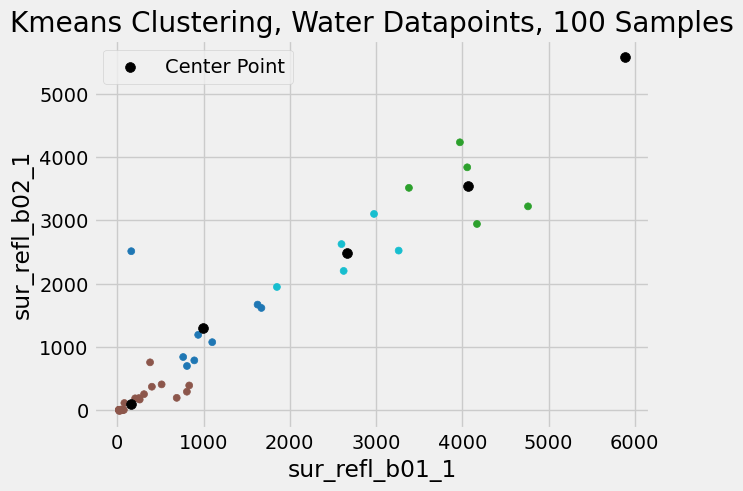

In [48]:
plt.scatter(X_water.values[:,0], X_water.values[:,1],
            c=kmeans_output_water,cmap='tab10',s=25)
plt.scatter(kme_water.cluster_centers_[:,0],kme_water.cluster_centers_[:,1],
            label='Center Point',c='k',s=50)
plt.title(f'Kmeans Clustering, Water Datapoints, {num_datapoints} Samples')
plt.legend()
plt.xlabel(X_water.columns[0])
plt.ylabel(X_water.columns[1])

Text(0, 0.5, 'sur_refl_b02_1')

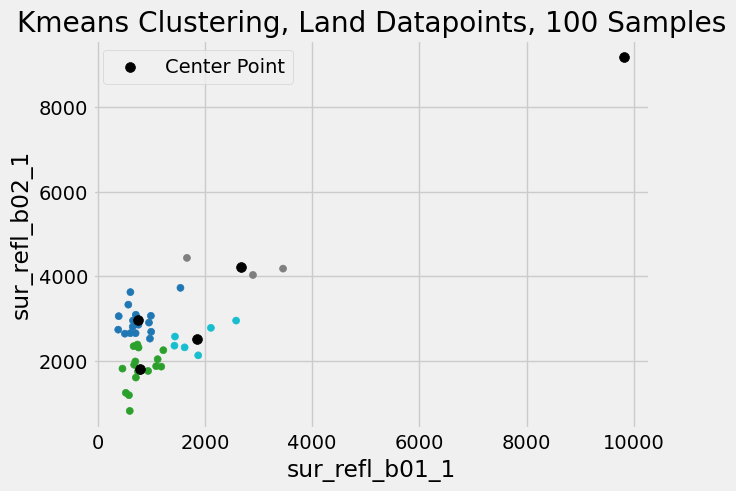

In [42]:
# plt.scatter(X_land.values[:,0], X_land.values[:,1],
#             c=kmeans_output_land,cmap='tab10',s=25)
# plt.scatter(kme_land.cluster_centers_[:,0],kme_land.cluster_centers_[:,1],
#             label='Center Point',c='k',s=50)
# plt.title(f'Kmeans Clustering, Land Datapoints, {num_datapoints} Samples')
# plt.legend()
# plt.xlabel(X_land.columns[0])
# plt.ylabel(X_land.columns[1])

### kmeans land versus water

In [74]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

#### varying cluster number

##### 5

In [75]:
CLUSTER_NUM=5

In [76]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 27.4 s, sys: 3.78 s, total: 31.1 s
Wall time: 3.83 s


In [77]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 31 s, sys: 4.04 s, total: 35.1 s
Wall time: 3.32 s


In [78]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)

water
1976791
[0 3 4 ... 3 0 0]
[[  26.58489648    7.05594394]
 [1157.89053436 1059.89802543]
 [5530.08697479 5540.42478992]
 [ 469.14441005  319.86639908]
 [1539.71196724 2783.27362354]]

land
2399030
[4 2 3 ... 3 3 2]
[[2092.74327357 3030.04407696]
 [ 463.7404102   947.29255108]
 [ 452.96388296 4099.01703769]
 [ 500.68183992 2954.52499397]
 [ 670.99987918 2083.88175109]]


##### 5 plot

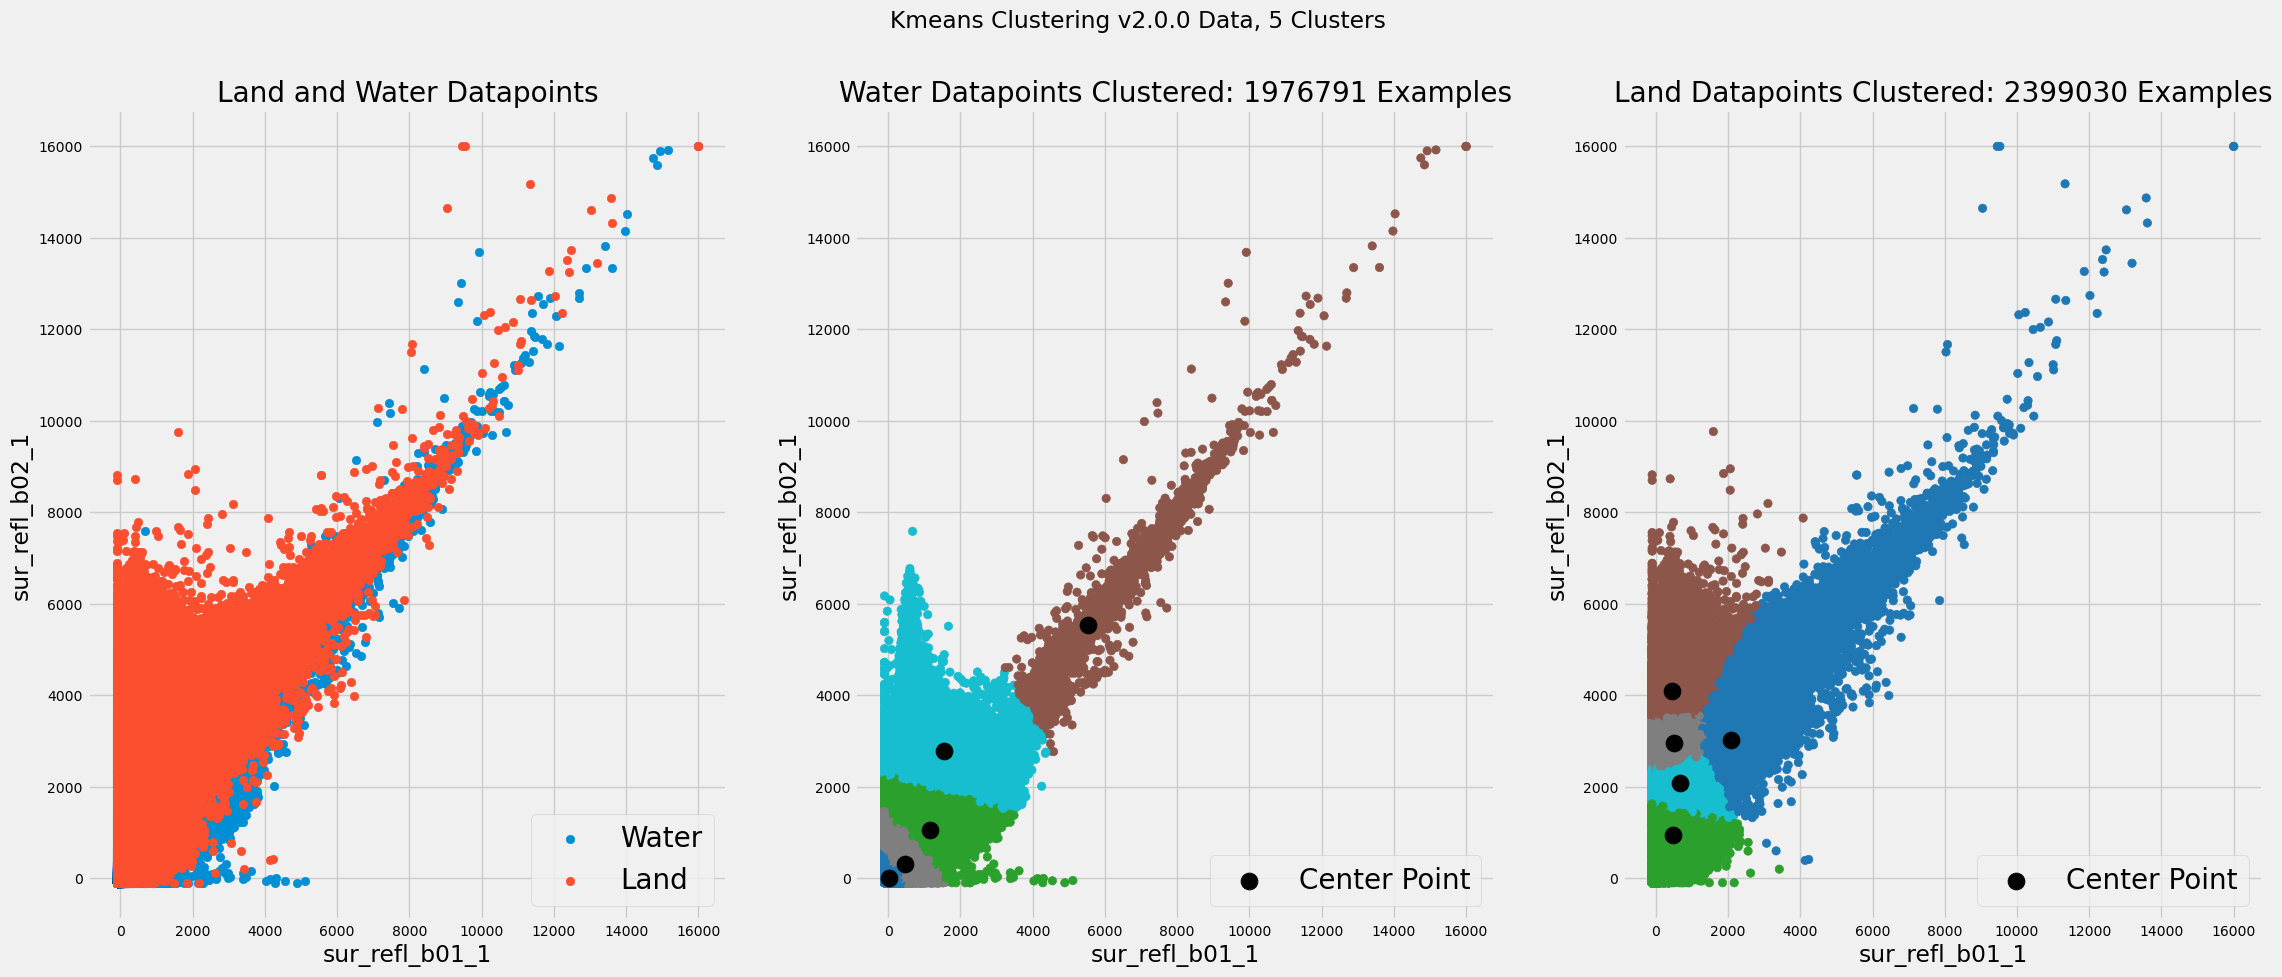

In [80]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 10

In [81]:
CLUSTER_NUM=10

In [82]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 34.7 s, sys: 5.04 s, total: 39.7 s
Wall time: 3.32 s


In [83]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 49.2 s, sys: 7.14 s, total: 56.4 s
Wall time: 4.75 s


In [92]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

water
1976791
[0 8 4 ... 9 8 0]
[[ 9.06917436e+00 -2.90345275e+00]
 [ 1.31316200e+03  8.36037392e+02]
 [ 5.28402039e+03  5.29786996e+03]
 [ 4.53058293e+02  5.08654662e+02]
 [ 9.78517735e+02  2.56923103e+03]
 [ 2.52149482e+03  2.32724609e+03]
 [ 3.92526372e+02  2.34346836e+02]
 [ 6.75658023e+02  1.01298843e+03]
 [ 1.86117573e+02  1.04515873e+02]
 [ 8.18588463e+02  3.64581828e+02]
 [ 1.06996632e+04  1.10223579e+04]
 [ 1.44658985e+03  1.65198661e+03]
 [ 3.78707454e+03  3.75959058e+03]
 [ 7.26358872e+03  7.30818562e+03]
 [ 7.96548698e+02  3.90795781e+03]]

land
2399030
[3 5 9 ... 9 2 5]
[[1050.3084974  3409.64082789]
 [ 459.40045593 1695.6382838 ]
 [ 388.79884329 3282.85672196]
 [ 481.21584859 2222.08954228]
 [ 438.66240769 4753.25658383]
 [ 412.49717333 3939.27906183]
 [2194.05817652 2999.30577088]
 [1565.52050821 2431.69559693]
 [5910.66375546 6661.20524017]
 [ 781.55685864 2712.8405921 ]
 [ 584.10723757 1083.21993664]
 [2907.76756033 3911.9995166 ]
 [ 252.76579338  386.20020348]
 [ 303.

15

##### 10 plot

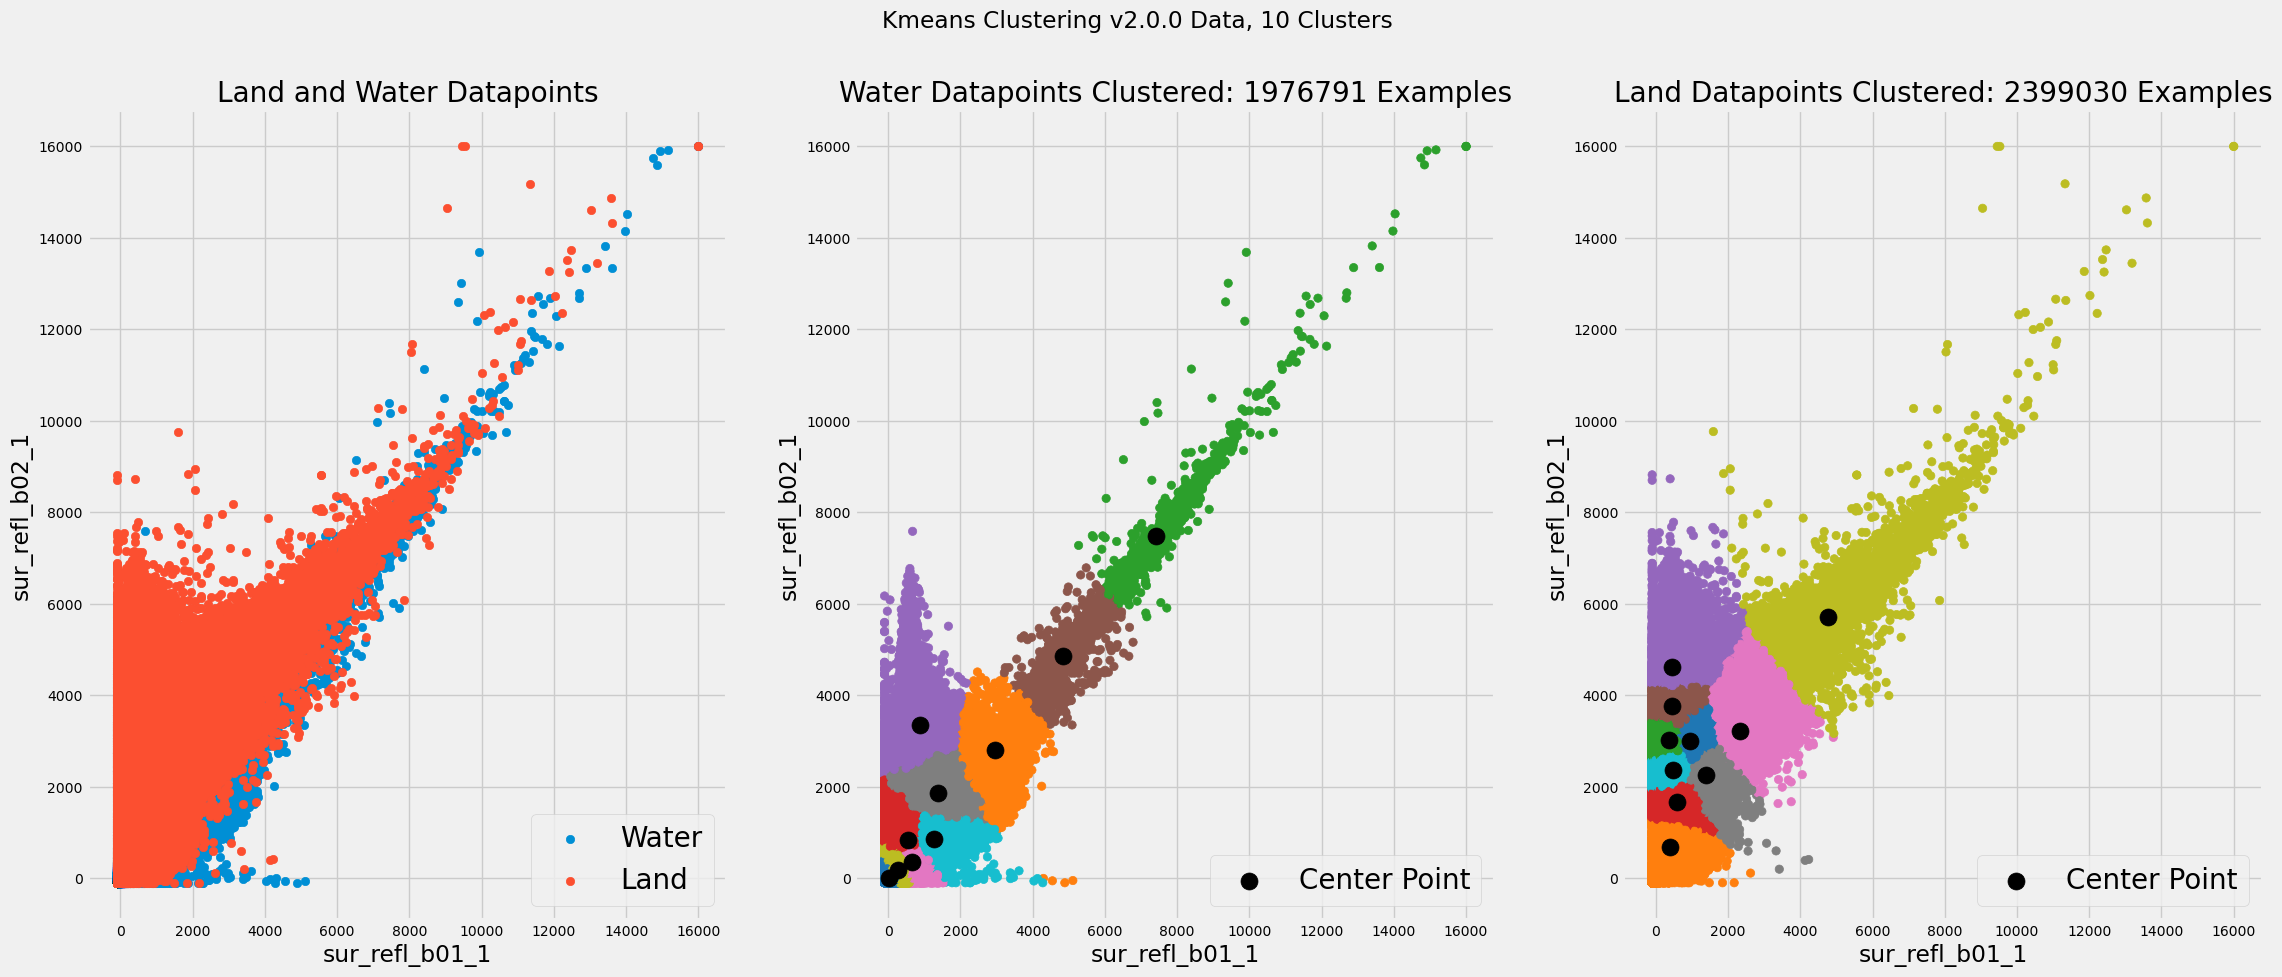

In [85]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 15

In [86]:
CLUSTER_NUM=15

In [87]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 55.4 s, sys: 6.05 s, total: 1min 1s
Wall time: 1.83 s


In [88]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 1min 18s, sys: 7.81 s, total: 1min 25s
Wall time: 2.4 s


In [90]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

water
1976791
[0 8 4 ... 9 8 0]
[[ 9.06917436e+00 -2.90345275e+00]
 [ 1.31316200e+03  8.36037392e+02]
 [ 5.28402039e+03  5.29786996e+03]
 [ 4.53058293e+02  5.08654662e+02]
 [ 9.78517735e+02  2.56923103e+03]
 [ 2.52149482e+03  2.32724609e+03]
 [ 3.92526372e+02  2.34346836e+02]
 [ 6.75658023e+02  1.01298843e+03]
 [ 1.86117573e+02  1.04515873e+02]
 [ 8.18588463e+02  3.64581828e+02]
 [ 1.06996632e+04  1.10223579e+04]
 [ 1.44658985e+03  1.65198661e+03]
 [ 3.78707454e+03  3.75959058e+03]
 [ 7.26358872e+03  7.30818562e+03]
 [ 7.96548698e+02  3.90795781e+03]]

land
2399030
[3 5 9 ... 9 2 5]
[[1050.3084974  3409.64082789]
 [ 459.40045593 1695.6382838 ]
 [ 388.79884329 3282.85672196]
 [ 481.21584859 2222.08954228]
 [ 438.66240769 4753.25658383]
 [ 412.49717333 3939.27906183]
 [2194.05817652 2999.30577088]
 [1565.52050821 2431.69559693]
 [5910.66375546 6661.20524017]
 [ 781.55685864 2712.8405921 ]
 [ 584.10723757 1083.21993664]
 [2907.76756033 3911.9995166 ]
 [ 252.76579338  386.20020348]
 [ 303.

15

##### 15 plot

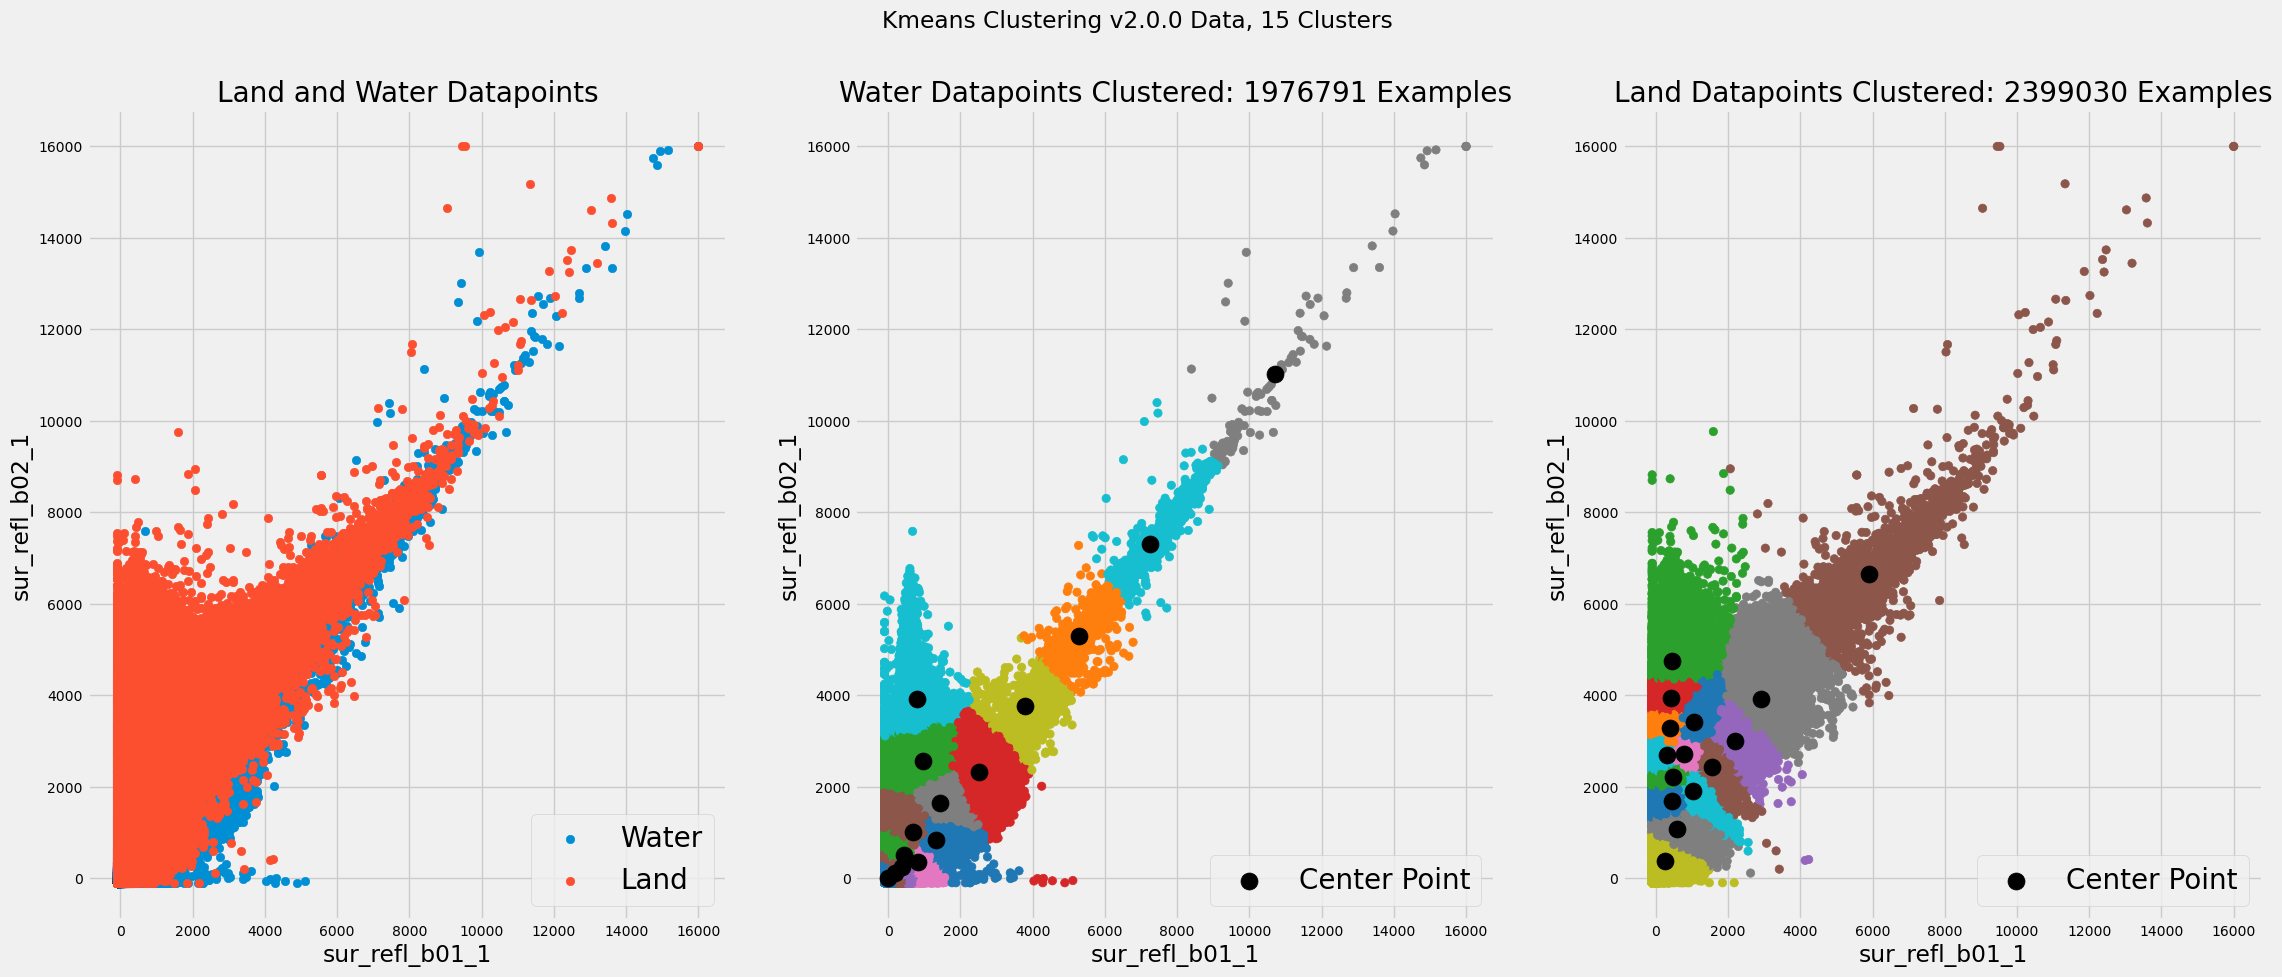

In [91]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 20

In [94]:
CLUSTER_NUM=20

In [95]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

CPU times: user 1min 14s, sys: 8.41 s, total: 1min 22s
Wall time: 2.3 s


In [96]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

CPU times: user 1min, sys: 6.76 s, total: 1min 6s
Wall time: 1.85 s


In [97]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

water
1976791
[19  8  4 ...  6 16 19]
[[-4.49822181e+01 -1.29587663e+01]
 [ 1.31497928e+03  1.09047783e+03]
 [ 6.13085052e+03  6.16001119e+03]
 [ 4.13943888e+02  4.53599552e+02]
 [ 9.81005320e+02  2.83940077e+03]
 [ 3.68067598e+03  3.64274760e+03]
 [ 7.08481567e+02  3.06244390e+02]
 [ 7.07765736e+02  1.71770279e+03]
 [ 3.56118281e+02  2.14289579e+02]
 [ 1.08349266e+03  5.37210783e+02]
 [ 1.15290508e+04  1.19966102e+04]
 [ 2.58718529e+03  2.55376294e+03]
 [ 4.83375357e+03  4.83453728e+03]
 [ 7.84780150e+03  7.89909023e+03]
 [ 7.47913231e+02  4.11881704e+03]
 [ 2.21897336e+03  1.30042256e+03]
 [ 1.83772318e+02  1.02679973e+02]
 [ 1.52100982e+03  1.87294339e+03]
 [ 6.34380340e+02  8.35956525e+02]
 [ 3.21449140e+01  1.47405702e+00]]

land
2399030
[ 3 19  9 ...  9  2 19]
[[1224.93440661 2837.34543411]
 [ 429.19496808 1538.31209336]
 [ 293.13877236 3075.13172353]
 [ 436.23445223 2033.0144591 ]
 [ 423.70330418 4959.2595715 ]
 [1213.85800979 3815.18287682]
 [2002.55229059 2761.12043694]
 [1475

20

##### 20 plot

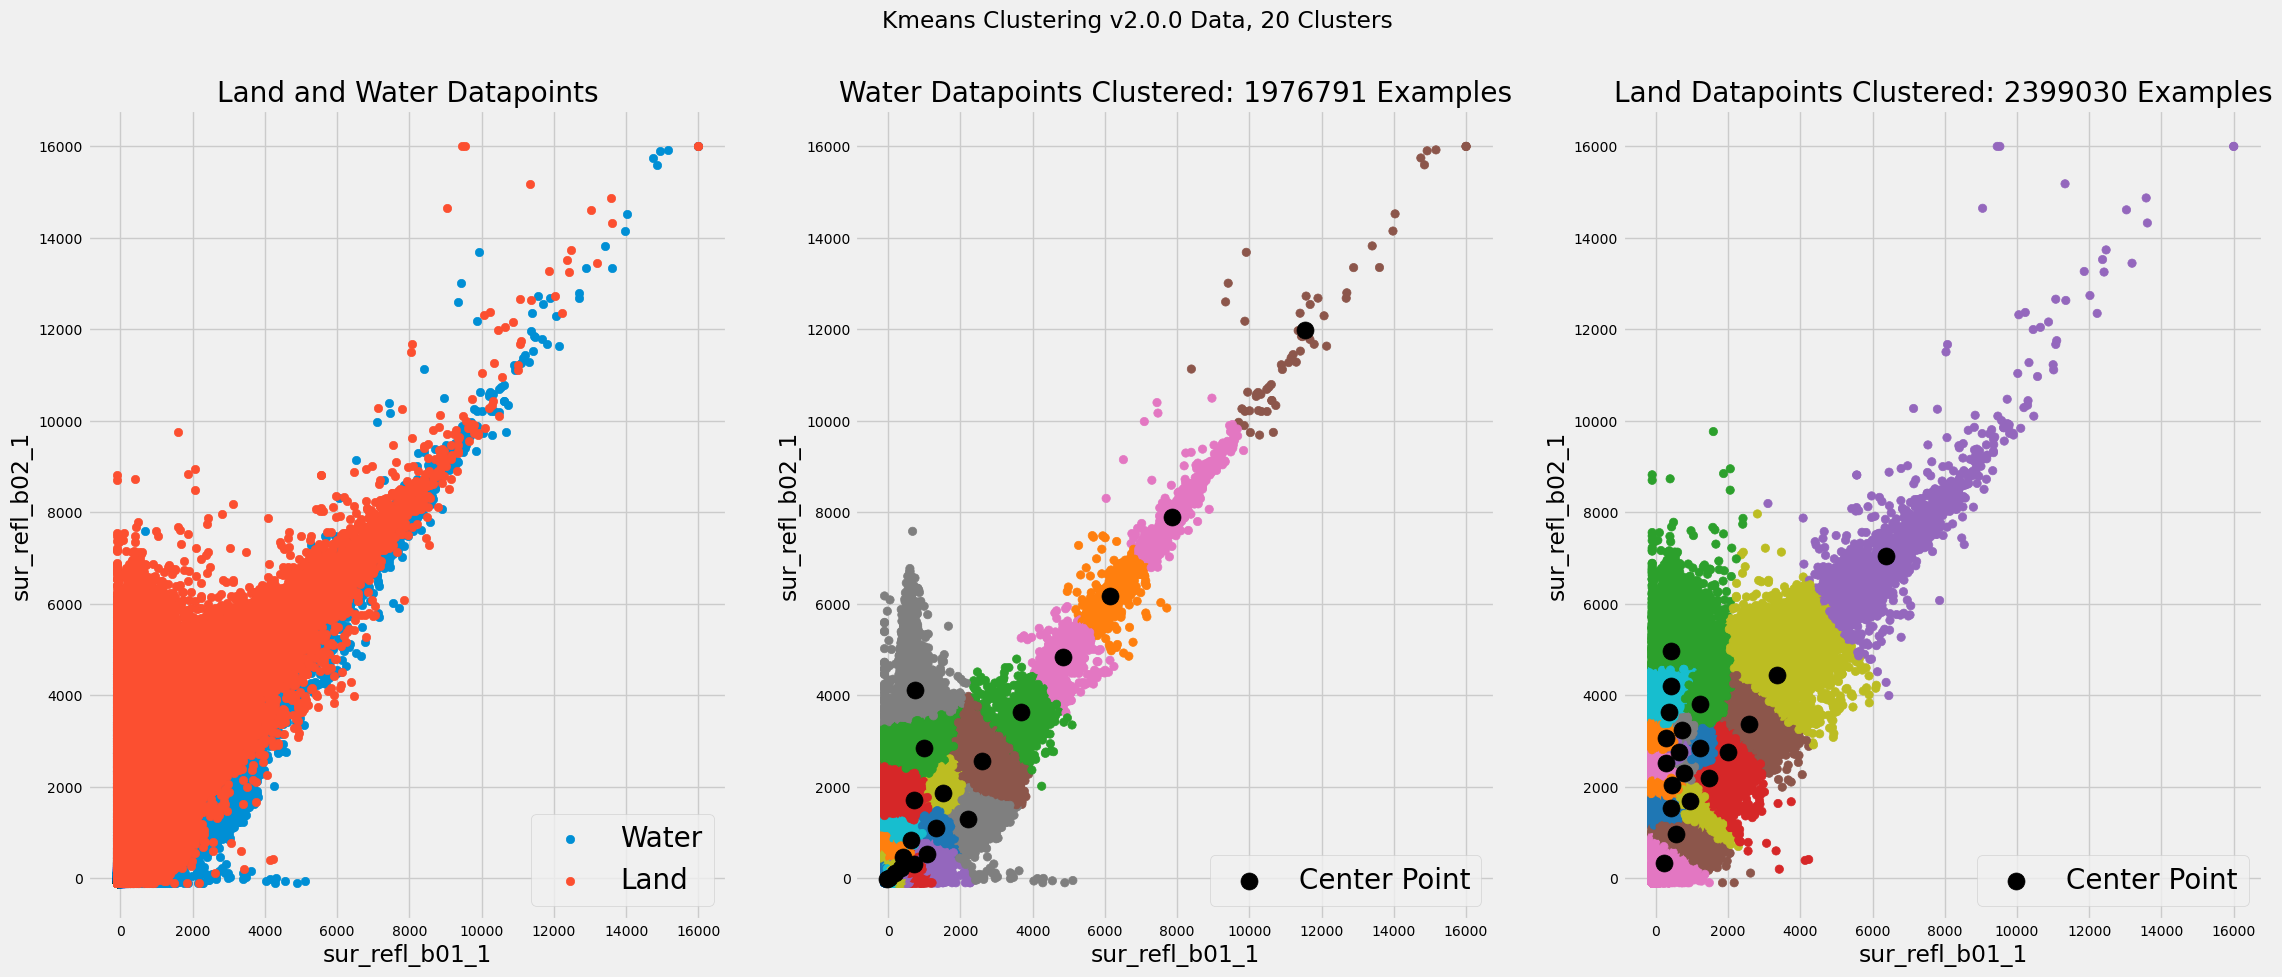

In [98]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 25

In [99]:
CLUSTER_NUM=25

In [ ]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

In [ ]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

##### 25 plot

In [ ]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

##### 30

In [93]:
CLUSTER_NUM=30

In [ ]:
%%time
kme_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land = kme_land.predict(X_land)

In [ ]:
%%time
kme_water =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water = kme_water.predict(X_water)

In [ ]:
print('water')
print(len(kmeans_output_water))
print(kmeans_output_water)
print(kme_water.cluster_centers_)
print()
print('land')
print(len(kmeans_output_land))
print(kmeans_output_land)
print(kme_land.cluster_centers_)
len(kme_land.cluster_centers_)

##### 30 plot

In [ ]:
plotting_clusters(X_water,X_land,kme_water,kme_land,kmeans_output_water,kmeans_output_land,CLUSTER_NUM)

### Birch

In [46]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

MemoryError: unable to allocate array data.

Text(0, 0.5, 'sur_refl_b02_1')

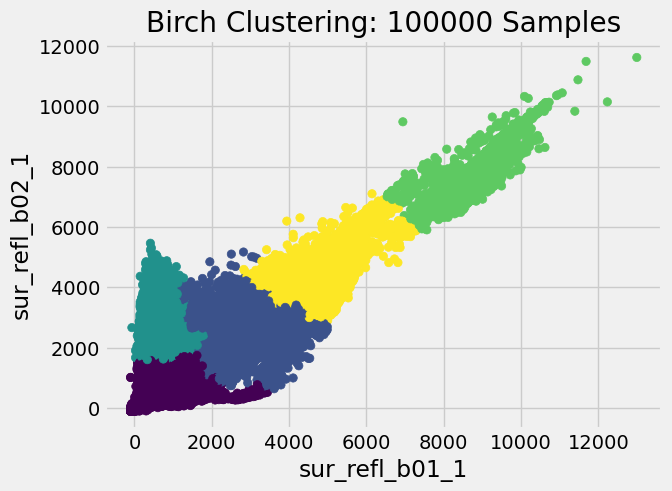

In [39]:
plt.scatter(X.values[:,0], X.values[:,1],c=birch_output)
plt.title(f'Birch Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

### Spectral 

In [17]:
%%time
spectral = SpectralClustering(
        n_clusters=5,
        #affinity="nearest_neighbors",
        random_state=42).fit_predict(X)

CPU times: user 42min 33s, sys: 3min 47s, total: 46min 21s
Wall time: 1min 10s


Text(0, 0.5, 'sur_refl_b02_1')

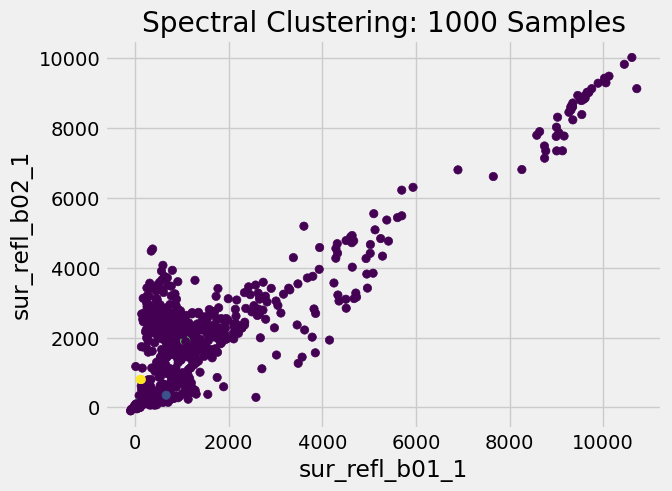

In [20]:
plt.scatter(X.values[:,0], X.values[:,1],c=spectral)
plt.title(f'Spectral Clustering: {num_datapoints} Samples')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

## Adding more input bands

In [49]:
colsToDrop = [
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [50]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'subset data shape: {X.shape}, {y.shape}')

Imbalancing data, sampling 0.5 from land, 0.5 from water
subset data shape: (100, 3), (100,)


In [55]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind_3D = np.where(y>0.5)[0]
y_land_ind_3D = np.where(y<0.5)[0]

#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_3D = X.iloc[y_water_ind_3D,:]
y_water_3D = y.iloc[y_water_ind_3D]

X_land_3D = X.iloc[y_land_ind_3D,:]
y_land_3D = y.iloc[y_land_ind_3D]

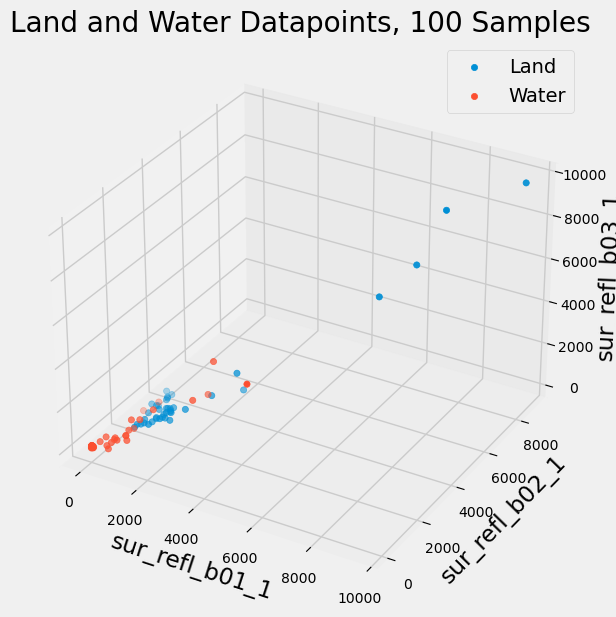

In [66]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.title(f'Land and Water Datapoints, {num_datapoints} Samples')
ax.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],label='Land')
ax.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],label='Water')

ax.set_xlabel(X_land.columns[0])
ax.set_ylabel(X_land.columns[1])
ax.set_zlabel(X_land.columns[2])
plt.legend()

plt.show()

### Kmeans

In [88]:
common_params = {
    "n_init": "auto",
    "random_state": 42,
}

In [89]:
%%time
kme_water_3D =  KMeans(n_clusters=5, **common_params).fit(X_water_3D)
kmeans_output_water_3D = kme_water_3D.predict(X_water_3D)

CPU times: user 65.2 ms, sys: 9.15 ms, total: 74.4 ms
Wall time: 6.91 ms


In [90]:
%%time
kme_land_3D =  KMeans(n_clusters=5, **common_params).fit(X_land_3D)
kmeans_output_land_3D = kme_land_3D.predict(X_land_3D)

CPU times: user 56 ms, sys: 8.16 ms, total: 64.1 ms
Wall time: 5.57 ms


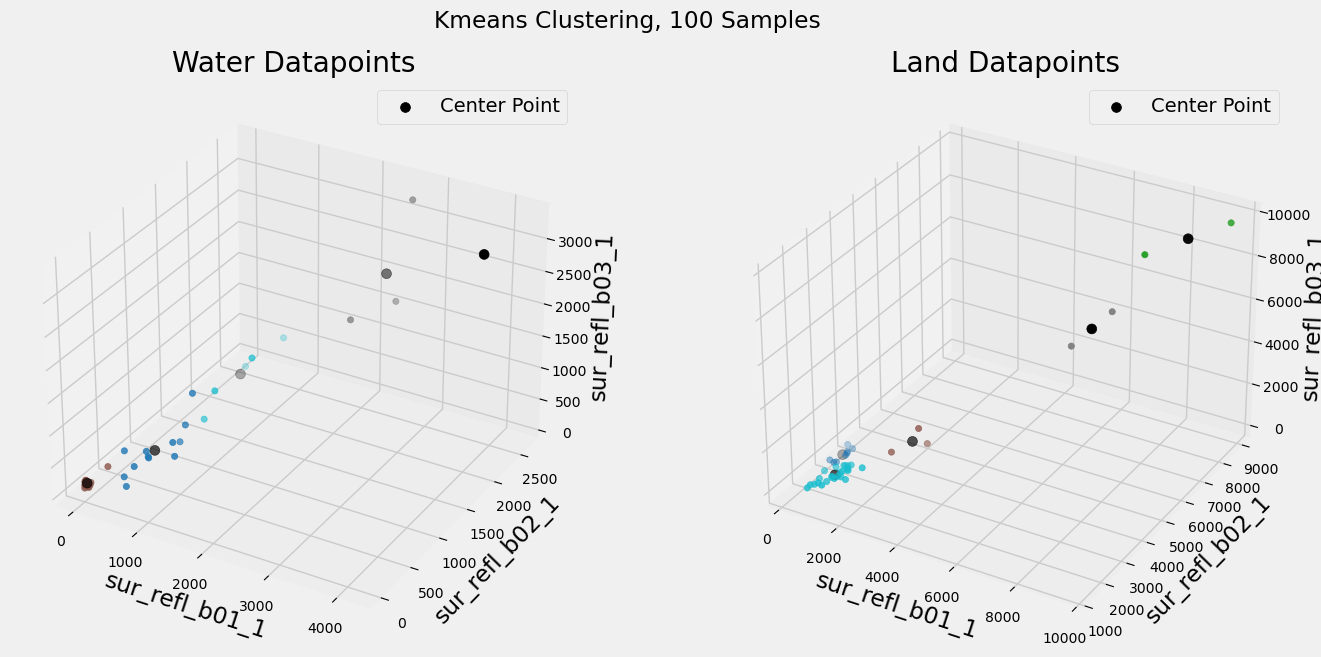

In [93]:
fig = plt.figure(figsize = (15, 7))

plt.suptitle(f'Kmeans Clustering, {num_datapoints} Samples')
ax1 = plt.subplot(121,projection ="3d")
# ax1 = plt.axes(projection ="3d")
ax1.set_title(f'Water Datapoints')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)

ax1.scatter(X_water_3D.values[:,0], X_water_3D.values[:,1], X_water_3D.values[:,2],
           marker='o',c=kmeans_output_water_3D,cmap='tab10')
ax1.scatter(kme_water_3D.cluster_centers_[:,0],kme_water_3D.cluster_centers_[:,1],kme_water_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax1.legend()
ax1.set_xlabel(X_water_3D.columns[0])
ax1.set_ylabel(X_water_3D.columns[1])
ax1.set_zlabel(X_water_3D.columns[2])


ax2 = plt.subplot(122,projection ="3d")
# ax2 = plt.axes(projection ="3d")
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='minor', labelsize=10)

ax2.set_title(f'Land Datapoints')
ax2.scatter(X_land_3D.values[:,0], X_land_3D.values[:,1], X_land_3D.values[:,2],
           marker='o',c=kmeans_output_land_3D,cmap='tab10')
ax2.scatter(kme_land_3D.cluster_centers_[:,0],kme_land_3D.cluster_centers_[:,1],kme_land_3D.cluster_centers_[:,2],
            label='Center Point',c='k',s=50)
ax2.legend()
ax2.set_xlabel(X_land_3D.columns[0])
ax2.set_ylabel(X_land_3D.columns[1])
ax2.set_zlabel(X_land_3D.columns[2])

plt.show()

### Birch

In [74]:
%%time
br = Birch(n_clusters=5).fit(X)
birch_output = br.predict(X)

CPU times: user 12.4 ms, sys: 11 ms, total: 23.4 ms
Wall time: 27.3 ms


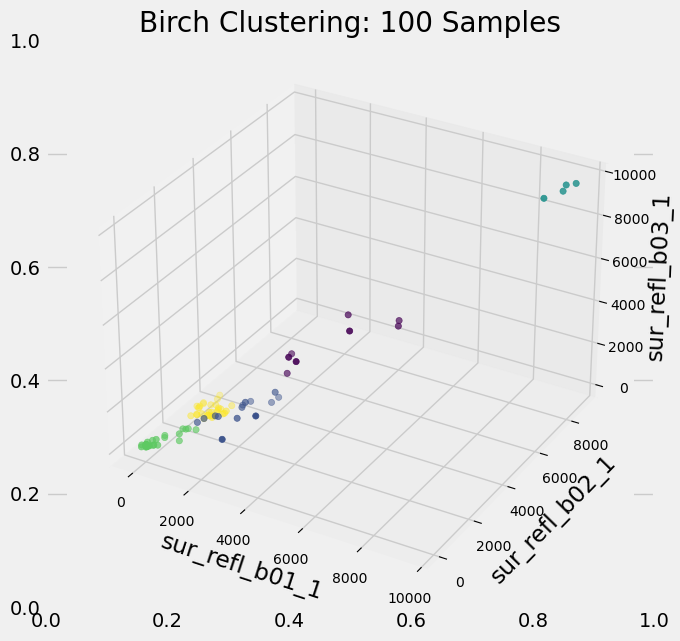

In [76]:
fig = plt.figure(figsize = (7, 7))
plt.title(f'Birch Clustering: {num_datapoints} Samples')
ax = plt.axes(projection ="3d")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X.values[:,0], X.values[:,1], X.values[:,2],marker='o',c=birch_output)

ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_zlabel(X.columns[2])

plt.show()

## Selecting Clustered Training Data

In [15]:
# List of the clusters: kmeans_output_land and kmeans_output_water
# Data: X_water, X_land, y_water, y_land

PERCENT_RANDOM_PULL = 0.1

In [16]:
np.random.seed(42)
random_ind_land = np.array([])
random_ind_water = []

for cluster in np.unique(kmeans_output_land):
    print(f'cluster {cluster}')

    cluster_ind_water = np.where(kmeans_output_water == cluster)[0]
    COUNT_RANDOM_PULL_WATER = int(0.1*len(cluster_ind_water))
    random_pts_water = np.random.choice(cluster_ind_water,COUNT_RANDOM_PULL_WATER,replace=False)
    random_ind_water = np.append(random_ind_water, random_pts_water)
    
    cluster_ind_land = np.where(kmeans_output_land == cluster)[0]
    COUNT_RANDOM_PULL_LAND = int(0.1*len(cluster_ind_land))
    random_pts_land = np.random.choice(cluster_ind_land,COUNT_RANDOM_PULL_LAND,replace=False)
    random_ind_land = np.append(random_ind_land, random_pts_land)
    print(f'Pulling {COUNT_RANDOM_PULL_WATER} Water pts and {COUNT_RANDOM_PULL_LAND} Land pts')
    print()
random_ind_water = random_ind_water.astype('int')
random_ind_land = random_ind_land.astype('int')

print(random_ind_water,random_ind_land)

cluster 0
Pulling 188931 Water pts and 61524 Land pts

cluster 1
Pulling 603 Water pts and 28417 Land pts

cluster 2
Pulling 8256 Water pts and 29916 Land pts

[1777936 1244689 1571074 ...  685151  977113 1670447] [ 645908 1192294  514467 ...  304363  584313  106968]


### Total random dataset used for training random forest

In [17]:
X_random_land = X_land.iloc[random_ind_land]
y_random_land = y_land.iloc[random_ind_land]
X_random_water = X_water.iloc[random_ind_water]
y_random_water = y_water.iloc[random_ind_water]

X_random = pd.concat([X_random_land,X_random_water])
y_random = pd.concat([y_random_land,y_random_water])

#Combine the data so that we can shuffle the indices and keep the data together that should be
All_data = pd.concat([X_random,y_random],axis=1).sample(frac=1)

X_random_rfa = All_data[X_random.columns]
y_random_rfa = All_data['water']

In [18]:
print(All_data)
print(X_random_rfa)
print(y_random_rfa)

         sur_refl_b01_1  sur_refl_b02_1  water
1115079              37              -2      1
530841              183            1862      0
2434087              25              -5      1
3481881             140              92      1
3542032             -96               3      1
...                 ...             ...    ...
3522117              -3               2      1
2803144             700            3286      0
1206096             -33             -20      1
2667991             -30               3      1
2015847             141             166      1

[317647 rows x 3 columns]
         sur_refl_b01_1  sur_refl_b02_1
1115079              37              -2
530841              183            1862
2434087              25              -5
3481881             140              92
3542032             -96               3
...                 ...             ...
3522117              -3               2
2803144             700            3286
1206096             -33             -20
2667991  

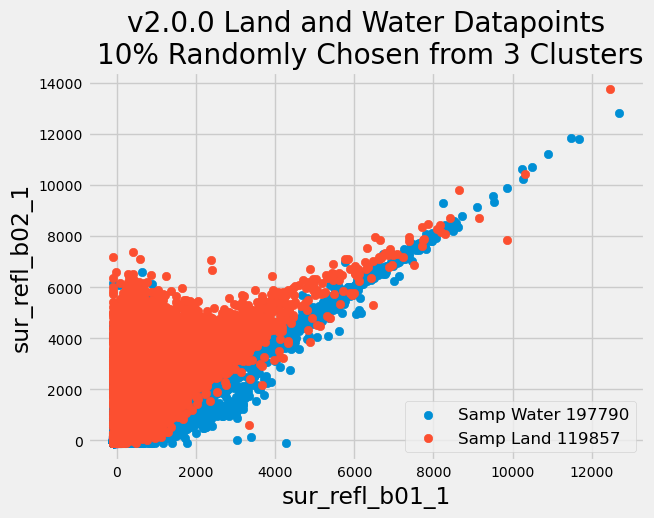

In [36]:
ax = plt.subplot(111)

#No random sample
# ax.scatter(X_water.values[:,0], X_water.values[:,1],label=f'All Water {len(y_water)}')
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
#Randomly sampled data
ax.scatter(X_random_water.values[:,0], X_random_water.values[:,1],label=f'Samp Water {len(y_random_water)}')
ax.scatter(X_random_land.values[:,0], X_random_land.values[:,1],label=f'Samp Land {len(y_random_land)}')

ax.set_title(f'{DATA_VERSION} Land and Water Datapoints'+ 
    f'\n {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend(loc='lower right',fontsize="12")
ax.set_xlabel(X_random_water.columns[0])
ax.set_ylabel(X_random_water.columns[1])

plt.show()

In [62]:

ax = plt.subplot(111)

#No random sample
ax.hist(X_water.values[:,0],label=f'All Water {len(y_water)}',alpha=0.8)
ax.hist(X_land.values[:,0],label=f'All Land {len(y_land)}', alpha=0.8)
ax.hist(X_random_water.values[:,0],label=f'Samp Water {len(y_random_water)}', alpha=0.8)
ax.hist(X_random_land.values[:,0], label=f'Samp Land {len(y_random_land)}',alpha=0.8) 
# ax.scatter(X_land.values[:,0], X_land.values[:,1],label=f'All Land {len(y_land)}')
# #Randomly sampled data
# ax.scatter(X_random_water.values[:,0], X_random_water.values[:,1],label=f'Samp Water {len(y_random_water)}')
# ax.scatter(X_random_land.values[:,0], X_random_land.values[:,1],label=f'Samp Land {len(y_random_land)}')

ax.set_title(f'{DATA_VERSION} Land and Water Datapoints'+ 
    f'\n {int(100*PERCENT_RANDOM_PULL)}% Randomly Chosen from {len(np.unique(kmeans_output_land))} Clusters')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend(loc='lower right',fontsize="12")
ax.set_xlabel(X_random_water.columns[0])
# ax.set_ylabel(X_random_water.columns[1])

plt.show()

SyntaxError: invalid syntax (684774838.py, line 8)

## Comparing targeted and random samples


In [41]:
DATA_VERSION='v4.2.0'
training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

#VERSION 4.2.0
TILE_IN = 'Golden'#v4.2.0
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)


X_target, X_test_target, y_target, y_test_target = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X_target = X_target.iloc[:num_datapoints,:] 
y_target = y_target.iloc[:num_datapoints] 

X_test_target = X_test_target.iloc[:num_datapoints,:] 
y_test_target = y_test_target.iloc[:num_datapoints] 

print(f'\n\ntarget subset data shape: {X_target.shape}, {y_target.shape}')

#Getting the indices that are associated with land (0) and water (1)
#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_target = X_target.iloc[np.where(y_target>0.5)[0],:]
X_land_target = X_target.iloc[np.where(y_target<0.5)[0],:]

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip', '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip
Imbalancing data, sampling 0.5 from land, 0.5 from water


target subset data shape: (576800, 2), (576800,)


In [44]:
DATA_VERSION='v2.0.0'
training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

#VERSION 4.2.0
TILE_IN = 'GLOBAL'#v4.2.0
offsets_indexes_rand = ['x_offset', 'y_offset', 'year', 'julian_day']

glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes_rand)

X_rand, X_test_rand, y_rand, y_test_rand = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=FRAC_LAND,
                                trainTestSplit=True
                                )

X_rand = X_rand.iloc[:num_datapoints,:] 
y_rand = y_rand.iloc[:num_datapoints] 

X_test_rand = X_test_rand.iloc[:num_datapoints,:] 
y_test_rand = y_test_rand.iloc[:num_datapoints] 

print(f'\n\nrandom subset data shape: {X_rand.shape}, {y_rand.shape}')

#Getting the indices that are associated with land (0) and water (1)
#Subset the X AND y data to later subset with the clusters and then combine for RFA
X_water_rand = X_rand.iloc[np.where(y_rand>0.5)[0],:]
X_land_rand = X_rand.iloc[np.where(y_rand<0.5)[0],:]


['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.0/MOD09_GLOBAL_5516128_2_0_0.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.0/MOD09_GLOBAL_5516128_2_0_0.parquet.gzip
Imbalancing data, sampling 0.5 from land, 0.5 from water


random subset data shape: (3176492, 2), (3176492,)


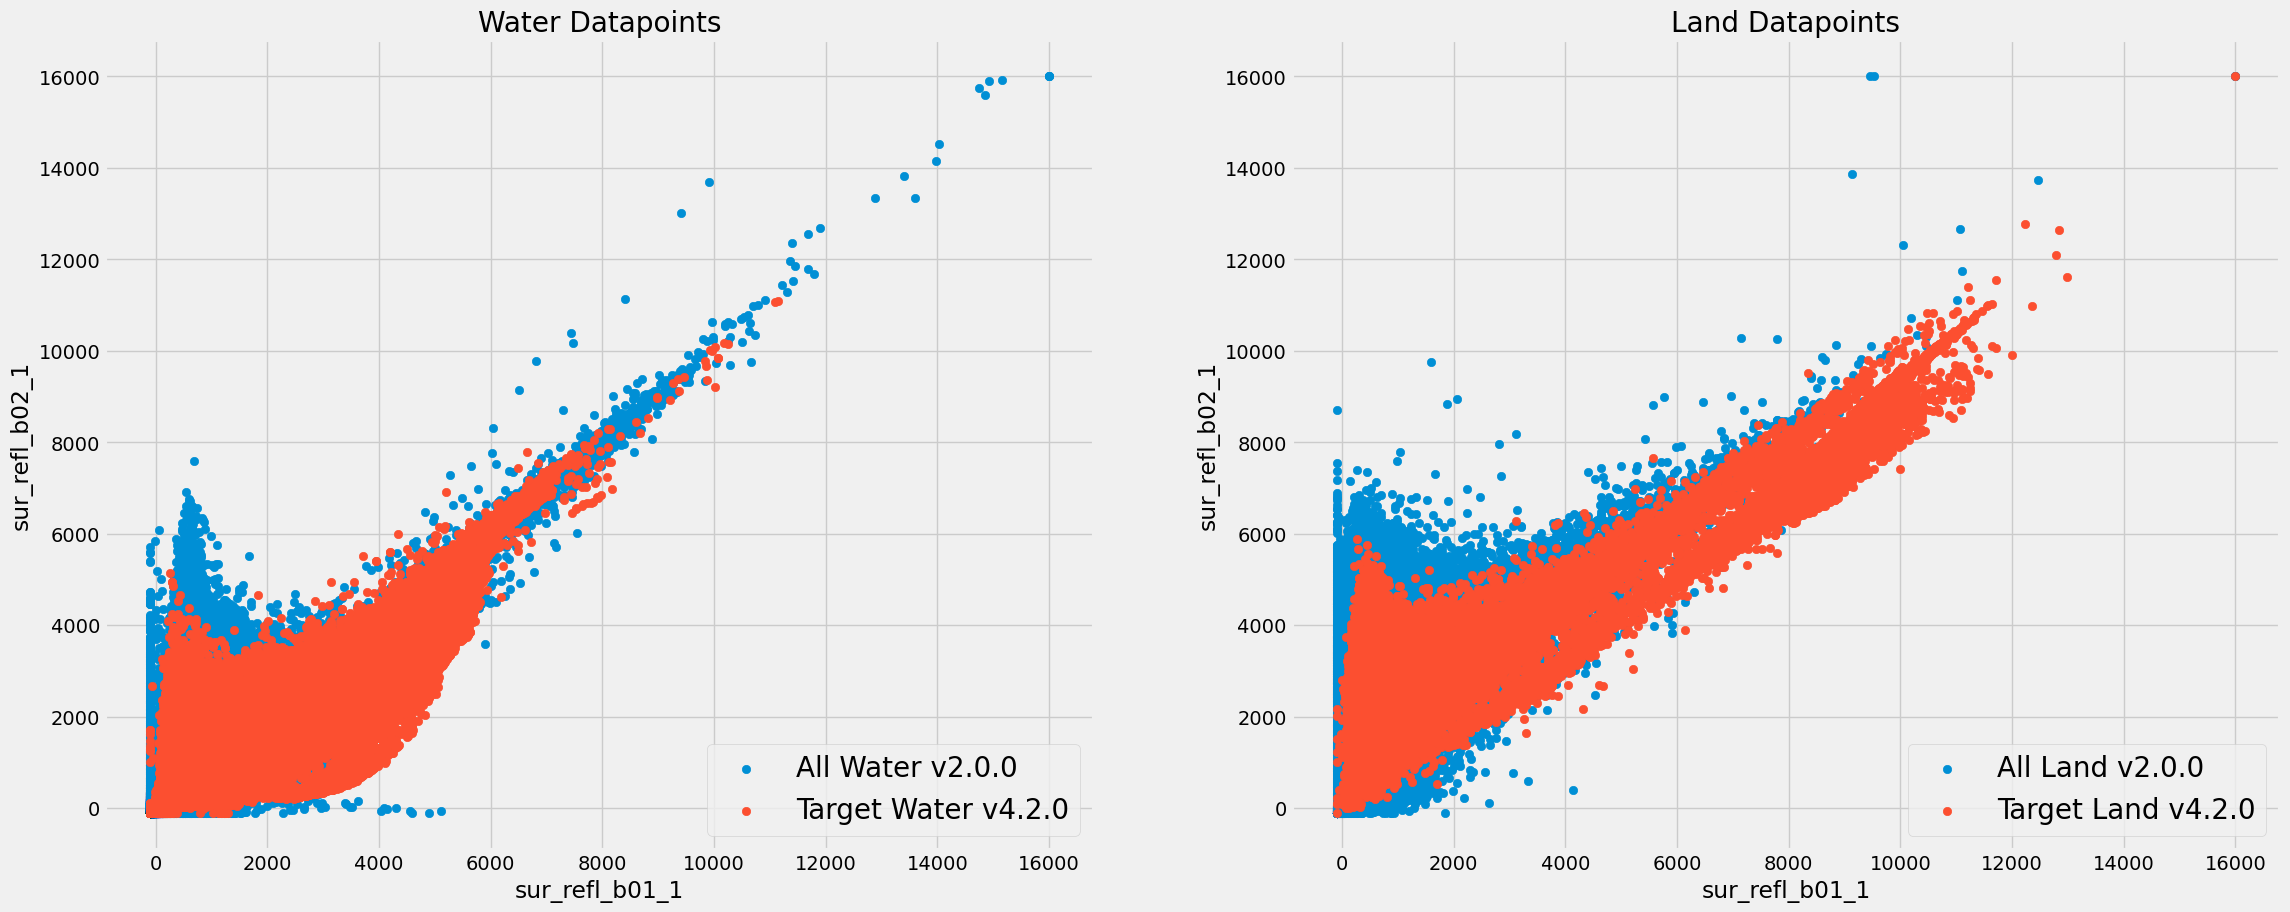

In [61]:
fig = plt.figure(figsize = (25, 10))

ax = plt.subplot(121)
ax.set_title(f'Water Datapoints')
ax.scatter(X_water_rand.values[:,0],X_water_rand.values[:,1],label=f'All Water v2.0.0')
ax.scatter(X_water_target.values[:,0],X_water_target.values[:,1],label=f'Target Water v4.2.0')
ax.legend(loc='lower right',fontsize="20")
ax.set_xlabel(X_land_rand.columns[0])
ax.set_ylabel(X_land_rand.columns[1])

ax1 = plt.subplot(122)
ax1.set_title(f'Land Datapoints')
ax1.scatter(X_land_rand.values[:,0],X_land_rand.values[:,1],label=f'All Land v2.0.0')
ax1.scatter(X_land_target.values[:,0],X_land_target.values[:,1],label=f'Target Land v4.2.0')
ax1.legend(loc='lower right',fontsize="20")
ax1.set_xlabel(X_land_rand.columns[0])
ax1.set_ylabel(X_land_rand.columns[1])

plt.show()

# Random forest training